In [1]:
# from bs4 import BeautifulSoup
# import requests
# import re
from itunes_app_scraper.scraper import AppStoreScraper

import numpy as np

import requests
import html
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

# Step 1

In [2]:
def fetch_app_list(url: str) -> str:
    response = requests.get(url)
    response.raise_for_status()
    return response.text


def build_dataframe(html_content: str) -> pd.DataFrame:
    clean_html = html.unescape(html_content)
    df = pd.read_html(StringIO(clean_html))[0]
    return df

list_url = "https://fabiosacerdote.github.io/ScrapingData/top_paid_apps_to_share.html"
html_content = fetch_app_list(list_url)
app_df = build_dataframe(html_content)
app_df.head()

,app_id,rank,name
0,479516143,1,Minecraft: Play with Friends
1,1118115766,2,Bloons TD 6
2,342548956,3,TurboScan™ Pro: PDF scanner
3,623592465,4,Heads Up!
4,625334537,5,Geometry Dash


# Step 2 

In [3]:
scraper = AppStoreScraper()
def get_selected_app_details(app_ids, country="us", lang="en"):
    """Fetch only the wanted fields for a list of app IDs."""
    details = scraper.get_multiple_app_details(app_ids, country=country, lang=lang, sleep=0)

    rows = []
    for d in details:
        if not d:
            continue
        rows.append({
            "id": d.get("trackId"),
            "price": d.get("price"),
            "currency": d.get("currency"),
            "genre": d.get("primaryGenreName"),
            "avg_score": d.get("averageUserRating") or d.get("averageUserRatingForCurrentVersion"),
            "reviews_count": d.get("userRatingCount") or d.get("userRatingCountForCurrentVersion"),
            "developer": d.get("artistName")
        })
    return pd.DataFrame(rows)

In [4]:
ids = app_df["app_id"].dropna().astype(int).tolist()
details_df = get_selected_app_details(ids)
full_df = app_df.merge(details_df, left_on="app_id", right_on="id", how="left")
full_df.head()

,app_id,rank,name,id,price,currency,genre,avg_score,reviews_count,developer
0,479516143,1,Minecraft: Play with Friends,4.795161e+08,6.99,USD,Games,4.50122,773878.0,Mojang
1,1118115766,2,Bloons TD 6,1.118116e+09,6.99,USD,Games,4.85886,325307.0,Ninja Kiwi
2,342548956,3,TurboScan™ Pro: PDF scanner,3.425490e+08,9.99,USD,Business,4.92556,289707.0,Piksoft Inc.
3,623592465,4,Heads Up!,6.235925e+08,1.99,USD,Games,4.79235,261015.0,Warner Bros.
4,625334537,5,Geometry Dash,6.253345e+08,2.99,USD,Games,4.52792,223505.0,RobTop Games AB


# Step 3

In [5]:
#assumption of 20 downloads per review
full_df["estimated_downloads"] = full_df["reviews_count"] * 20

Check the relation between downloads and rank, as the rank should be a good proxy for the number of downloads

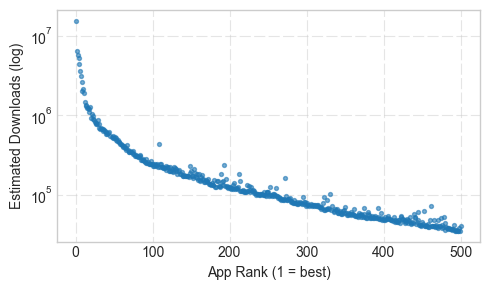

In [30]:
fig = plt.figure(figsize=(5, 3))
plt.grid(alpha = 0.5, ls = (5, (10, 3)))

plt.scatter(full_df['rank'], full_df['estimated_downloads'], alpha=0.6, s=8)

plt.xlabel('App Rank (1 = best)')
plt.ylabel('Estimated Downloads (log)')
plt.yscale('log')

plt.tight_layout()
plt.savefig('../output/plots/rank_vs_downloads.png', dpi=300, bbox_inches='tight')
plt.show()

Now map categories into macrocategories to have less than 10 cathegories

In [7]:
category_counts = full_df["genre"].value_counts()
category_counts

genre
Games                214
Photo & Video         38
Health & Fitness      28
Utilities             20
Productivity          19
Weather               18
Education             16
Music                 15
Lifestyle             15
Reference             14
Travel                13
Entertainment         13
Navigation            13
Business              11
Medical               10
Finance                9
Social Networking      8
Food & Drink           6
Shopping               5
Sports                 4
News                   2
Name: count, dtype: int64

In [8]:
#Define macro-categories mapping
macro_map = {
    "Games": "Games",
    "Entertainment": "Entertainment",
    "Music": "Entertainment",
    "Photo & Video": "Entertainment",
    "Social Networking": "Social",
    "Shopping": "E-commerce",
    "Food & Drink": "Lifestyle",
    "Health & Fitness": "Lifestyle",
    "Lifestyle": "Lifestyle",
    "Travel": "Travel",
    "Navigation": "Travel",
    "Business": "Productivity",
    "Productivity": "Productivity",
    "Utilities": "Productivity",
    "Finance": "Finance",
    "Medical": "Health",
    "Reference": "Education",
    "Education": "Education",
    "Weather": "Weather",
    "Sports": "Sports",
    "News": "News"
}
full_df["macro_category"] = full_df["genre"].map(macro_map)
macro_counts = full_df.groupby("macro_category").size().sort_values(ascending=False)

outside_good = full_df.groupby("genre").size()[lambda x: x < 10]

full_df["final_category"] = full_df.apply(
    lambda row: "Outside Good" if row["genre"] in outside_good.index else row["macro_category"],
    axis=1
)

final_counts = full_df["final_category"].value_counts()
print(final_counts)
full_df

final_category
Games            214
Entertainment     66
Productivity      50
Lifestyle         43
Outside Good      34
Education         30
Travel            26
Weather           18
Health            10
Name: count, dtype: int64


,app_id,rank,name,id,price,currency,genre,avg_score,reviews_count,developer,estimated_downloads,macro_category,final_category
0,479516143,1,Minecraft: Play with Friends,4.795161e+08,6.99,USD,Games,4.50122,773878.0,Mojang,15477560.0,Games,Games
1,1118115766,2,Bloons TD 6,1.118116e+09,6.99,USD,Games,4.85886,325307.0,Ninja Kiwi,6506140.0,Games,Games
2,342548956,3,TurboScan™ Pro: PDF scanner,3.425490e+08,9.99,USD,Business,4.92556,289707.0,Piksoft Inc.,5794140.0,Productivity,Productivity
3,623592465,4,Heads Up!,6.235925e+08,1.99,USD,Games,4.79235,261015.0,Warner Bros.,5220300.0,Games,Games
4,625334537,5,Geometry Dash,6.253345e+08,2.99,USD,Games,4.52792,223505.0,RobTop Games AB,4470100.0,Games,Games
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1413887036,496,iMPC Pro 2 for iPhone,1.413887e+09,12.99,USD,Music,4.65674,1780.0,Akai Professional,35600.0,Entertainment,Entertainment
496,521577043,497,VinoCell - wine cellar manager,5.215770e+08,9.99,USD,Food & Drink,4.64821,1788.0,VinoDev,35760.0,Lifestyle,Outside Good
497,510119487,498,AnatomyMapp,5.101195e+08,19.99,USD,Medical,4.80921,1955.0,Books of Discovery,39100.0,Health,Health
498,924491991,499,Cs Music Pro,9.244920e+08,2.99,USD,Music,4.30213,1784.0,Mike Clay,35680.0,Entertainment,Entertainment


In [9]:
full_df.to_csv("../output/data/apple_processed.csv", index=False)

# Statistics and tables

In [27]:
def smart_format(x):
    if isinstance(x, (int, np.integer)):   # integers untouched
        return f"{x:d}"
    if abs(x) < 1000:                      # small floats normal
        return f"{x:.2f}"
    else:                                  # large numbers in scientific notation
        return f"{x:.2e}"

numeric_df = full_df.select_dtypes(include=[np.number]).drop(columns=['rank', 'id'], errors='ignore')

#mean, median, std, min, max, count
summary = pd.DataFrame({
    "mean": numeric_df.mean(),
    "median": numeric_df.median(),
    "std": numeric_df.std(),
    "min": numeric_df.min(),
    "max": numeric_df.max(),
    "count": numeric_df.count()
})
summary = summary[["mean", "median", "std", "min", "max", "count"]]

summary = summary.map(smart_format)
summary.to_latex("../output/tables/numeric_summary.tex", float_format="%.2f")

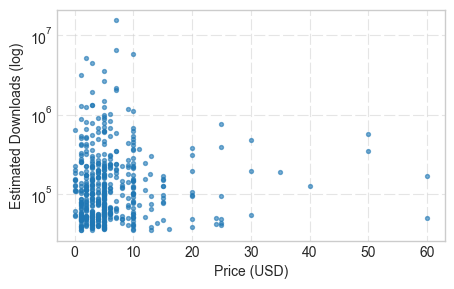

In [31]:
#Scatter plot for price vs estimated downloads
plt.figure(figsize=(5, 3))
plt.grid(alpha = 0.5, ls = (5, (10, 3)))

plt.scatter(data=full_df, x='price', y='estimated_downloads', alpha=0.6, s=8)

plt.yscale('log')
plt.xlabel('Price (USD)')
plt.ylabel('Estimated Downloads (log)')

plt.savefig('../output/plots/price_vs_downloads.png', dpi=300, bbox_inches='tight')
plt.show()